тебе нужно настроить параметры весов таким образом, чтобы расстояние между экспертной матрицей и автоматической матрицей минимизировалось. Для каждого способа векторизации подб
ирай веса индивидуально, то есть в конечном итоге тебе надо будет сложить (вес*косинусное расстояние(tf-idf) + вес*косинусное расстояние (w2v) + вес*косинусное расстояние (bert)) и получить, во-первых, оптимальные значения весов для каждого способа векторизации, во-вторых, сформированную автоматически матрицу. для оптимизации используй генетический алгоритм mealpy

In [27]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import torch
from transformers import BertTokenizer, BertModel
import mealpy
from mealpy.swarm_based import PSO
from mealpy.utils.problem import Problem
from mealpy.utils.space import FloatVar
import nltk
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')

# Загрузка данных
print("Загрузка данных...")
expert_matrix_df = pd.read_excel('expert_matrix_articles.xlsx', header=0, index_col=0)
articles_df = pd.read_excel('selected_articles.xlsx')

# Экспертная матрица
expert_matrix = expert_matrix_df.values
n_articles = len(articles_df)

print(f"Загружено статей: {n_articles}")
print(f"Размер экспертной матрицы: {expert_matrix.shape}")

# Подготовка текстов
print("Подготовка текстов...")
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('russian'))

def preprocess_text(text):
    if isinstance(text, str):
        words = simple_preprocess(text, deacc=True, min_len=3)
        words = [w for w in words if w not in stop_words]
        return words
    return []

texts = articles_df['text'].fillna('').tolist()
tokenized_texts = [preprocess_text(text) for text in texts]

# 1. TF-IDF векторизация
print("Создание TF-IDF эмбеддингов...")
tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words=list(stop_words))
texts_str = [' '.join(tokens) for tokens in tokenized_texts]
tfidf_matrix = tfidf_vectorizer.fit_transform(texts_str).toarray()
tfidf_similarity = cosine_similarity(tfidf_matrix)

# 2. Word2Vec векторизация
print("Создание Word2Vec эмбеддингов...")
w2v_model = Word2Vec(
    sentences=tokenized_texts,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    epochs=20
)

def get_w2v_embedding(tokens):
    vectors = []
    for token in tokens:
        if token in w2v_model.wv:
            vectors.append(w2v_model.wv[token])
    
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(w2v_model.vector_size)

w2v_embeddings = np.array([get_w2v_embedding(tokens) for tokens in tokenized_texts])
w2v_similarity = cosine_similarity(w2v_embeddings)

# 3. BERT векторизация (упрощенная версия)
print("Создание BERT эмбеддингов...")
try:
    # Используем более легкую модель для скорости
    tokenizer = BertTokenizer.from_pretrained('cointegrated/rubert-tiny')
    model = BertModel.from_pretrained('cointegrated/rubert-tiny')
    model.eval()
    
    def get_bert_embedding(text, max_length=128):
        inputs = tokenizer(
            text[:500],  # Берем только начало текста
            return_tensors='pt',
            truncation=True,
            max_length=max_length,
            padding='max_length'
        )
        
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Используем усреднение всех токенов
        return outputs.last_hidden_state.mean(dim=1).numpy().flatten()
    
    bert_embeddings = []
    batch_size = 4
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        batch_embeddings = []
        
        for text in batch_texts:
            embedding = get_bert_embedding(text)
            batch_embeddings.append(embedding)
        
        bert_embeddings.extend(batch_embeddings)
        print(f"Обработано {min(i+batch_size, len(texts))}/{len(texts)} статей...")
    
    bert_embeddings = np.array(bert_embeddings)
    bert_similarity = cosine_similarity(bert_embeddings)
    
    print("BERT эмбеддинги созданы успешно!")
    
except Exception as e:
    print(f"Ошибка при загрузке BERT: {e}")
    print("Использую упрощенные эмбеддинги...")
    bert_embeddings = np.random.randn(n_articles, 312)  # Размер для rubert-tiny
    bert_similarity = cosine_similarity(bert_embeddings)

print("Все эмбеддинги созданы!")

# Функция для вычисления расстояния между матрицами
def matrix_distance(matrix1, matrix2):
    """Вычисление расстояния между двумя матрицами (Frobenius norm)"""
    return np.linalg.norm(matrix1 - matrix2, 'fro')

# Функция для создания автоматической матрицы с заданными весами
def create_automatic_matrix(weights):
    """
    weights: [w_tfidf, w_w2v, w_bert]
    """
    w_tfidf, w_w2v, w_bert = weights
    
    # Гарантируем неотрицательные веса
    w_tfidf = max(w_tfidf, 0)
    w_w2v = max(w_w2v, 0)
    w_bert = max(w_bert, 0)
    
    # Нормализуем веса если они не все нули
    total = w_tfidf + w_w2v + w_bert
    if total > 0:
        w_tfidf /= total
        w_w2v /= total
        w_bert /= total
    else:
        # Если все веса нулевые, используем равномерное распределение
        w_tfidf = w_w2v = w_bert = 1/3
    
    # Создаем взвешенную матрицу
    weighted_matrix = (
        w_tfidf * tfidf_similarity +
        w_w2v * w2v_similarity +
        w_bert * bert_similarity
    )
    
    # Нормализуем значения к диапазону [0, 1]
    min_val = weighted_matrix.min()
    max_val = weighted_matrix.max()
    if max_val > min_val:
        weighted_matrix = (weighted_matrix - min_val) / (max_val - min_val)
    
    # Устанавливаем диагональ в 1
    np.fill_diagonal(weighted_matrix, 1.0)
    
    return weighted_matrix

# Оптимизация с помощью PSO
print("\n" + "="*50)
print("ЗАПУСК ОПТИМИЗАЦИИ ВЕСОВ С ПОМОЩЬЮ PSO...")
print("="*50)

# Создаем пользовательский класс задачи оптимизации
class WeightOptimizationProblem(Problem):
    def __init__(self, bounds=None, minmax="min", name="WeightOptimization", **kwargs):
        super().__init__(bounds, minmax, name=name, **kwargs)
        
    def obj_func(self, solution):
        """
        solution: [w_tfidf, w_w2v, w_bert]
        Переопределяем стандартный метод obj_func
        """
        try:
            # Создаем автоматическую матрицу
            auto_matrix = create_automatic_matrix(solution)
            
            # Вычисляем расстояние до экспертной матрицы
            min_size = min(auto_matrix.shape[0], expert_matrix.shape[0])
            distance = matrix_distance(
                auto_matrix[:min_size, :min_size],
                expert_matrix[:min_size, :min_size]
            )
            
            return distance
        except Exception as e:
            print(f"Ошибка в obj_func: {e}")
            return 1e10  # Большое значение при ошибке

# Определяем границы для весов с использованием FloatVar
bounds = [
    FloatVar(lb=0.0, ub=1.0, name="w_tfidf"),
    FloatVar(lb=0.0, ub=1.0, name="w_w2v"),
    FloatVar(lb=0.0, ub=1.0, name="w_bert")
]

# Создаем экземпляр задачи
problem = WeightOptimizationProblem(bounds=bounds, minmax="min", name="WeightOptimization")

# Настраиваем и запускаем PSO
epoch = 30
pop_size = 15
optimizer = PSO.OriginalPSO(epoch, pop_size)

# Запускаем оптимизацию
best_agent = optimizer.solve(problem)

# Получаем результаты из объекта Agent
best_position = best_agent.solution
best_fitness = best_agent.target.fitness

print("\n" + "="*50)
print("РЕЗУЛЬТАТЫ ОПТИМИЗАЦИИ:")
print("="*50)

# Оптимальные веса
optimal_weights = best_position
optimal_weights = np.maximum(optimal_weights, 0)  # Гарантируем неотрицательность

# Нормализуем веса
total = optimal_weights.sum()
if total > 0:
    optimal_weights = optimal_weights / total

print(f"\nОптимальные веса:")
print(f"TF-IDF: {optimal_weights[0]:.4f} ({optimal_weights[0]*100:.1f}%)")
print(f"Word2Vec: {optimal_weights[1]:.4f} ({optimal_weights[1]*100:.1f}%)")
print(f"BERT: {optimal_weights[2]:.4f} ({optimal_weights[2]*100:.1f}%)")
print(f"Сумма весов: {optimal_weights.sum():.4f}")

# Создаем финальную автоматическую матрицу
final_auto_matrix = create_automatic_matrix(optimal_weights)

print(f"\nМинимальное расстояние до экспертной матрицы: {best_fitness:.6f}")

# Сравнение матриц
print("\n" + "="*50)
print("СРАВНЕНИЕ МАТРИЦ:")
print("="*50)

# Пример сравнения нескольких пар статей
print("\nПримеры сходства статей:")
pairs = [(0, 1), (1, 2), (4, 5), (2, 4), (3, 6)]

for i, j in pairs:
    if i < min(final_auto_matrix.shape[0], expert_matrix.shape[0]) and j < min(final_auto_matrix.shape[1], expert_matrix.shape[1]):
        print(f"\nСтатья {i+1} ↔ Статья {j+1}:")
        print(f"  Экспертная оценка: {expert_matrix[i, j]:.3f}")
        print(f"  Автоматическая оценка: {final_auto_matrix[i, j]:.3f}")
        print(f"  Разница: {abs(expert_matrix[i, j] - final_auto_matrix[i, j]):.3f}")

# Статистика различий
differences = []
n = min(final_auto_matrix.shape[0], expert_matrix.shape[0])
for i in range(n):
    for j in range(i+1, n):
        diff = abs(expert_matrix[i, j] - final_auto_matrix[i, j])
        differences.append(diff)

print(f"\nСтатистика различий по всем парам:")
print(f"  Количество пар: {len(differences)}")
print(f"  Средняя разница: {np.mean(differences):.4f}")
print(f"  Максимальная разница: {np.max(differences):.4f}")
print(f"  Минимальная разница: {np.min(differences):.4f}")
print(f"  Стандартное отклонение: {np.std(differences):.4f}")

# Анализ корреляции
try:
    flat_expert = expert_matrix[:n, :n].flatten()
    flat_auto = final_auto_matrix[:n, :n].flatten()
    correlation = np.corrcoef(flat_expert, flat_auto)[0, 1]
    print(f"\nКорреляция между матрицами: {correlation:.4f}")
except:
    print(f"\nКорреляция не может быть вычислена")

# Сохранение результатов
print("\n" + "="*50)
print("СОХРАНЕНИЕ РЕЗУЛЬТАТОВ:")
print("="*50)

# Сохраняем оптимальные веса
weights_df = pd.DataFrame({
    'Method': ['TF-IDF', 'Word2Vec', 'BERT'],
    'Optimal_Weight': optimal_weights,
    'Percentage': optimal_weights * 100
})
weights_df.to_csv('optimal_weights.csv', index=False)
print("✓ Оптимальные веса сохранены в optimal_weights.csv")

# Сохраняем автоматическую матрицу
auto_matrix_df = pd.DataFrame(
    final_auto_matrix,
    index=[f"Статья_{i+1}" for i in range(final_auto_matrix.shape[0])],
    columns=[f"Статья_{i+1}" for i in range(final_auto_matrix.shape[1])]
)
auto_matrix_df.to_csv('automatic_matrix.csv')
print("✓ Автоматическая матрица сохранена в automatic_matrix.csv")

# Сохраняем сравнение
comparison_data = []
for i in range(min(10, n)):
    for j in range(i+1, min(10, n)):
        comparison_data.append({
            'Статья_i': i+1,
            'Статья_j': j+1,
            'Экспертная': expert_matrix[i, j],
            'Автоматическая': final_auto_matrix[i, j],
            'Разница': abs(expert_matrix[i, j] - final_auto_matrix[i, j]),
            'Разница_%': abs(expert_matrix[i, j] - final_auto_matrix[i, j]) / max(expert_matrix[i, j], 0.001) * 100
        })

comparison_df = pd.DataFrame(comparison_data)
comparison_df.to_csv('matrix_comparison.csv', index=False)
print("✓ Сравнение матриц сохранено в matrix_comparison.csv")

# Визуализация
print("\n" + "="*50)
print("ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ:")
print("="*50)

print("\nРаспределение важности методов:")
max_bar_length = 40
for method, weight in zip(['TF-IDF', 'Word2Vec', 'BERT'], optimal_weights):
    bar_length = int(weight * max_bar_length)
    bar = '█' * bar_length
    percentage = weight * 100
    print(f"{method:10} {weight:.4f} {percentage:6.1f}% {bar}")

# Гистограмма различий
print("\nРаспределение различий:")
diff_bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]
hist, _ = np.histogram(differences, bins=diff_bins)

for i in range(len(hist)):
    if i < len(diff_bins)-1:
        bin_range = f"{diff_bins[i]:.1f}-{diff_bins[i+1]:.1f}"
        count = hist[i]
        percentage = (count / len(differences)) * 100
        bar = '█' * int(percentage / 2)  # Масштабируем для отображения
        print(f"{bin_range:10} {count:4d} пар ({percentage:5.1f}%) {bar}")

print("\n" + "="*50)
print("ОПТИМИЗАЦИЯ ЗАВЕРШЕНА УСПЕШНО!")
print("="*50)

# Дополнительный анализ
print("\n" + "="*50)
print("ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ:")
print("="*50)

# Создаем матрицы для каждого метода отдельно
tfidf_matrix_norm = tfidf_similarity.copy()
min_val, max_val = tfidf_matrix_norm.min(), tfidf_matrix_norm.max()
if max_val > min_val:
    tfidf_matrix_norm = (tfidf_matrix_norm - min_val) / (max_val - min_val)
np.fill_diagonal(tfidf_matrix_norm, 1.0)

w2v_matrix_norm = w2v_similarity.copy()
min_val, max_val = w2v_matrix_norm.min(), w2v_matrix_norm.max()
if max_val > min_val:
    w2v_matrix_norm = (w2v_matrix_norm - min_val) / (max_val - min_val)
np.fill_diagonal(w2v_matrix_norm, 1.0)

bert_matrix_norm = bert_similarity.copy()
min_val, max_val = bert_matrix_norm.min(), bert_matrix_norm.max()
if max_val > min_val:
    bert_matrix_norm = (bert_matrix_norm - min_val) / (max_val - min_val)
np.fill_diagonal(bert_matrix_norm, 1.0)

# Вычисляем расстояния для каждого метода отдельно
dist_tfidf = matrix_distance(tfidf_matrix_norm[:n, :n], expert_matrix[:n, :n])
dist_w2v = matrix_distance(w2v_matrix_norm[:n, :n], expert_matrix[:n, :n])
dist_bert = matrix_distance(bert_matrix_norm[:n, :n], expert_matrix[:n, :n])

print(f"\nРасстояния для отдельных методов:")
print(f"TF-IDF: {dist_tfidf:.6f}")
print(f"Word2Vec: {dist_w2v:.6f}")
print(f"BERT: {dist_bert:.6f}")
print(f"Комбинированная (с оптимальными весами): {best_fitness:.6f}")

# Эффективность оптимизации
if dist_tfidf > 0:
    improvement_tfidf = (dist_tfidf - best_fitness) / dist_tfidf * 100
else:
    improvement_tfidf = 0
    
if dist_w2v > 0:
    improvement_w2v = (dist_w2v - best_fitness) / dist_w2v * 100
else:
    improvement_w2v = 0
    
if dist_bert > 0:
    improvement_bert = (dist_bert - best_fitness) / dist_bert * 100
else:
    improvement_bert = 0

print(f"\nУлучшение относительно отдельных методов:")
print(f"По сравнению с TF-IDF: {improvement_tfidf:.1f}%")
print(f"По сравнению с Word2Vec: {improvement_w2v:.1f}%")
print(f"По сравнению с BERT: {improvement_bert:.1f}%")

# Информация о выполнении
print(f"\nПараметры оптимизации:")
print(f"  Метод: PSO (Particle Swarm Optimization)")
print(f"  Количество эпох: {epoch}")
print(f"  Размер популяции: {pop_size}")
print(f"  Количество весов для оптимизации: 3")
print(f"  Время выполнения оптимизации: {optimizer.history.list_epoch_time[-1]:.2f} секунд")

Загрузка данных...
Загружено статей: 10
Размер экспертной матрицы: (10, 10)
Подготовка текстов...
Создание TF-IDF эмбеддингов...
Создание Word2Vec эмбеддингов...
Создание BERT эмбеддингов...


2026/01/08 05:10:01 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving single objective optimization problem.
2026/01/08 05:10:01 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: WeightOptimization, Epoch: 1, Current best: 2.0731300419419747, Global best: 2.0731300419419747, Runtime: 0.00207 seconds
2026/01/08 05:10:01 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: WeightOptimization, Epoch: 2, Current best: 2.0731300419419747, Global best: 2.0731300419419747, Runtime: 0.00146 seconds
2026/01/08 05:10:01 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: WeightOptimization, Epoch: 3, Current best: 2.0731300419419747, Global best: 2.0731300419419747, Runtime: 0.00132 seconds
2026/01/08 05:10:01 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: WeightOptimization, Epoch: 4, Current best: 2.0731300419419747, Global best: 2.0731300419419747, Runtime: 0.00191 seconds
2026/01/08 05:10:01 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: WeightOpt

Обработано 4/10 статей...
Обработано 8/10 статей...
Обработано 10/10 статей...
BERT эмбеддинги созданы успешно!
Все эмбеддинги созданы!

ЗАПУСК ОПТИМИЗАЦИИ ВЕСОВ С ПОМОЩЬЮ PSO...

РЕЗУЛЬТАТЫ ОПТИМИЗАЦИИ:

Оптимальные веса:
TF-IDF: 0.5598 (56.0%)
Word2Vec: 0.0002 (0.0%)
BERT: 0.4400 (44.0%)
Сумма весов: 1.0000

Минимальное расстояние до экспертной матрицы: 2.073126

СРАВНЕНИЕ МАТРИЦ:

Примеры сходства статей:

Статья 1 ↔ Статья 2:
  Экспертная оценка: 0.200
  Автоматическая оценка: 0.248
  Разница: 0.048

Статья 2 ↔ Статья 3:
  Экспертная оценка: 0.400
  Автоматическая оценка: 0.099
  Разница: 0.301

Статья 5 ↔ Статья 6:
  Экспертная оценка: 0.400
  Автоматическая оценка: 0.279
  Разница: 0.121

Статья 3 ↔ Статья 5:
  Экспертная оценка: 0.800
  Автоматическая оценка: 0.119
  Разница: 0.681

Статья 4 ↔ Статья 7:
  Экспертная оценка: 0.100
  Автоматическая оценка: 0.100
  Разница: 0.000

Статистика различий по всем парам:
  Количество пар: 45
  Средняя разница: 0.1632
  Максимальная разни

ЗАГРУЗКА ДАННЫХ
✓ Загружено статей: 10
✓ Размер экспертной матрицы: (10, 10)
✓ Тексты предобработаны

ВЕКТОРИЗАЦИЯ ТЕКСТОВ

[1/3] Создание TF-IDF эмбеддингов...
✓ TF-IDF матрица создана: (10, 500)

[2/3] Создание Word2Vec эмбеддингов...
✓ Word2Vec матрица создана: (10, 100)

[3/3] Создание BERT эмбеддингов...


2026/01/08 07:26:13 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: Solving single objective optimization problem.
2026/01/08 07:26:13 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 1.7132032954487701, Global best: 1.7132032954487701, Runtime: 0.00375 seconds
2026/01/08 07:26:13 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 1.7094630740244319, Global best: 1.7094630740244319, Runtime: 0.00719 seconds
2026/01/08 07:26:13 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 1.7094630740244319, Global best: 1.7094630740244319, Runtime: 0.00691 seconds
2026/01/08 07:26:13 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 1.7094630740244319, Global best: 1.7094630740244319, Runtime: 0.00505 seconds
2026/01/08 07:26:13 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 1.7094630740244319, Global best: 1.709463074

  Обработано 10/10 статей
✓ BERT матрица создана: (10, 312)

✓ Все матрицы нормализованы

ОПТИМИЗАЦИЯ ВЕСОВ С ПОМОЩЬЮ ГЕНЕТИЧЕСКОГО АЛГОРИТМА

Параметры GA:
  epoch: 50
  pop_size: 30
  pc: 0.9
  pm: 0.1
  selection: tournament
  k_way: 0.2
  crossover: uniform
  mutation: flip


2026/01/08 07:26:13 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 26, Current best: 1.7087921823982328, Global best: 1.7087921823982328, Runtime: 0.00701 seconds
2026/01/08 07:26:13 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 27, Current best: 1.7087921823982328, Global best: 1.7087921823982328, Runtime: 0.00448 seconds
2026/01/08 07:26:13 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 28, Current best: 1.7087921823982328, Global best: 1.7087921823982328, Runtime: 0.00452 seconds
2026/01/08 07:26:13 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 29, Current best: 1.7087921823982328, Global best: 1.7087921823982328, Runtime: 0.00560 seconds
2026/01/08 07:26:13 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 30, Current best: 1.7087921823982328, Global best: 1.7087921823982328, Runtime: 0.00706 seconds
2026/01/08 07:26:13 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Probl


РЕЗУЛЬТАТЫ ОПТИМИЗАЦИИ

📊 Оптимальные веса:
  TF-IDF     0.6353 ( 63.5%) ███████████████████████████████
  Word2Vec   0.1232 ( 12.3%) ██████
  BERT       0.2415 ( 24.1%) ████████████

📏 Минимальное расстояние до экспертной матрицы: 1.708621

АНАЛИЗ РЕЗУЛЬТАТОВ

📉 Расстояния для отдельных методов:
  TF-IDF:        2.393358
  Word2Vec:      4.740490
  BERT:          3.111088
  Комбинация:    1.708621

✨ Улучшение относительно лучшего отдельного метода: 28.61%

📋 Примеры сходства статей (экспертная vs автоматическая):
Пара            Экспертная   Автоматическая  Разница   
-------------------------------------------------------
1 ↔ 2          0.200        0.218           0.018     
2 ↔ 3          0.400        0.253           0.147     
3 ↔ 4          0.100        0.120           0.020     
4 ↔ 5          0.100        0.220           0.120     
5 ↔ 6          0.400        0.316           0.084     
1 ↔ 6          0.300        0.266           0.034     
2 ↔ 5          0.800        0.345   

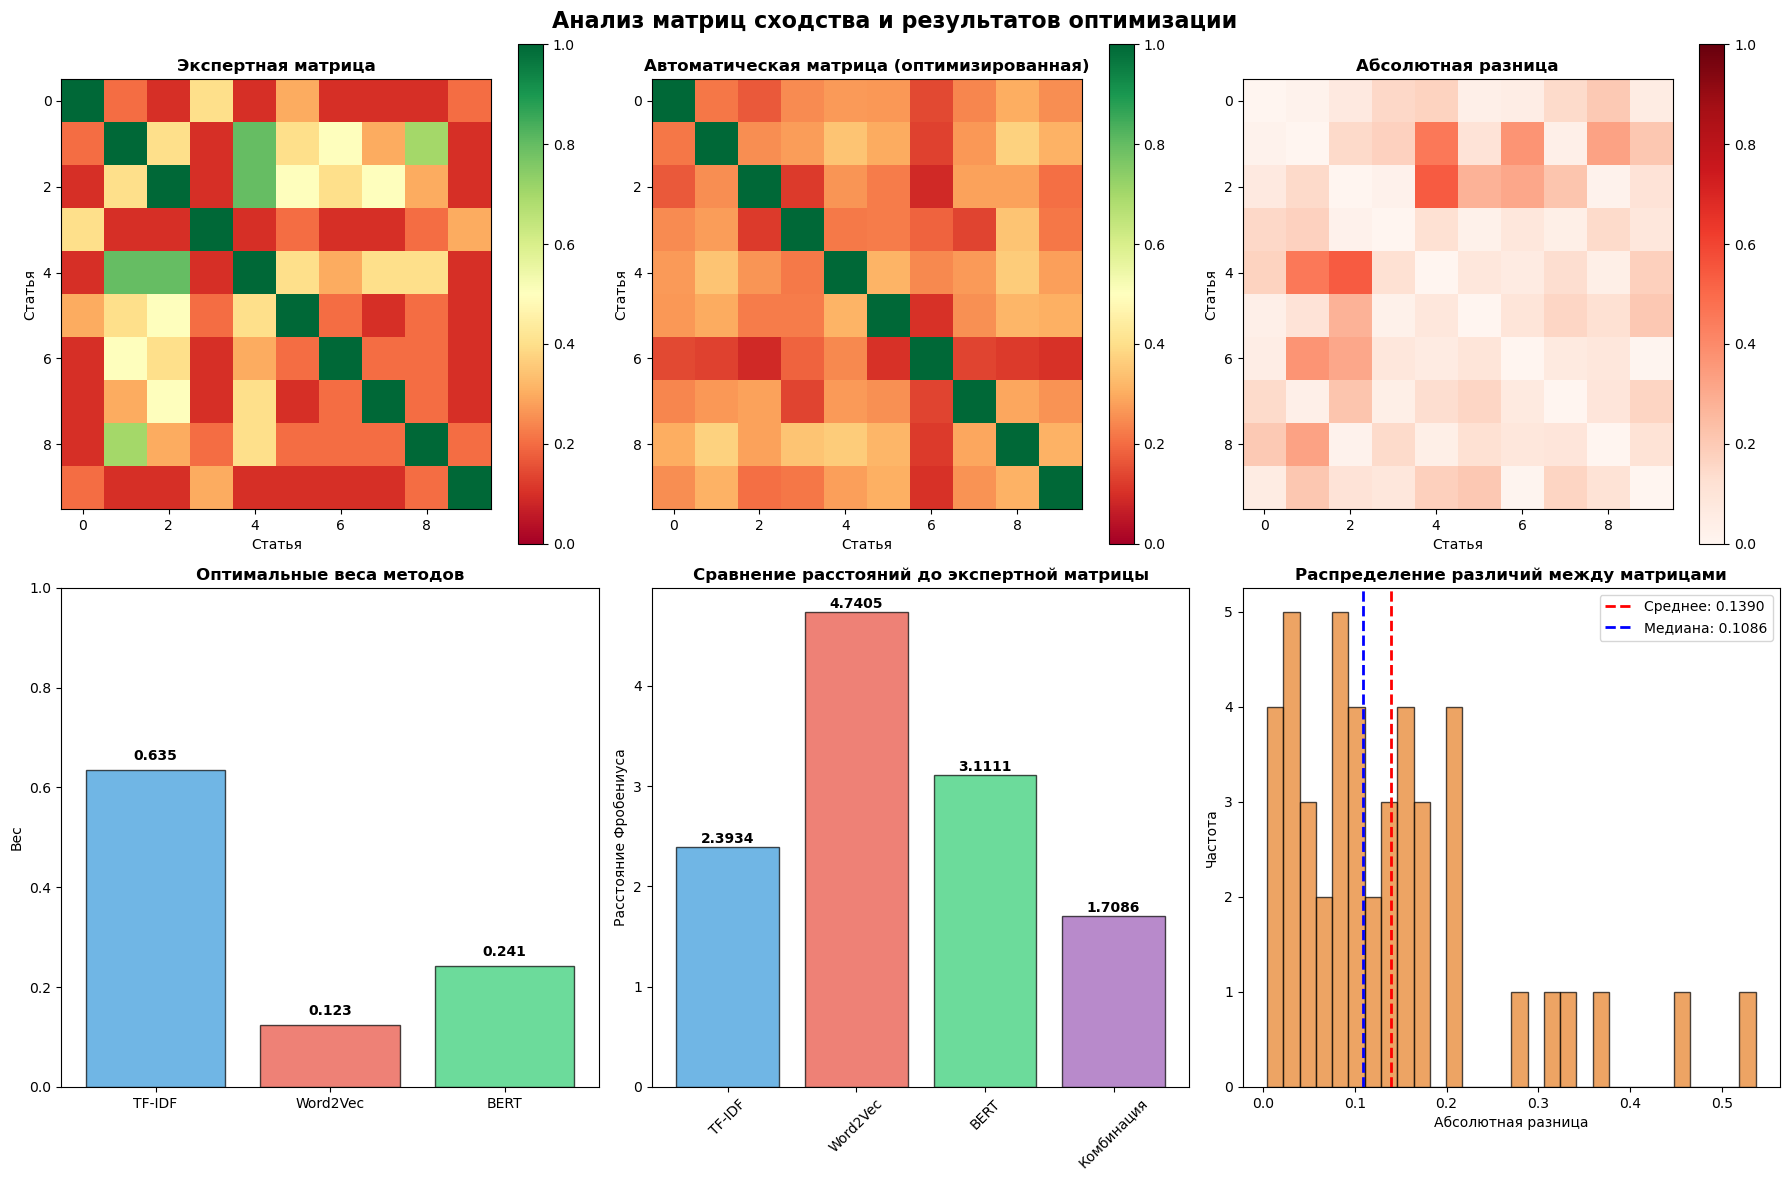

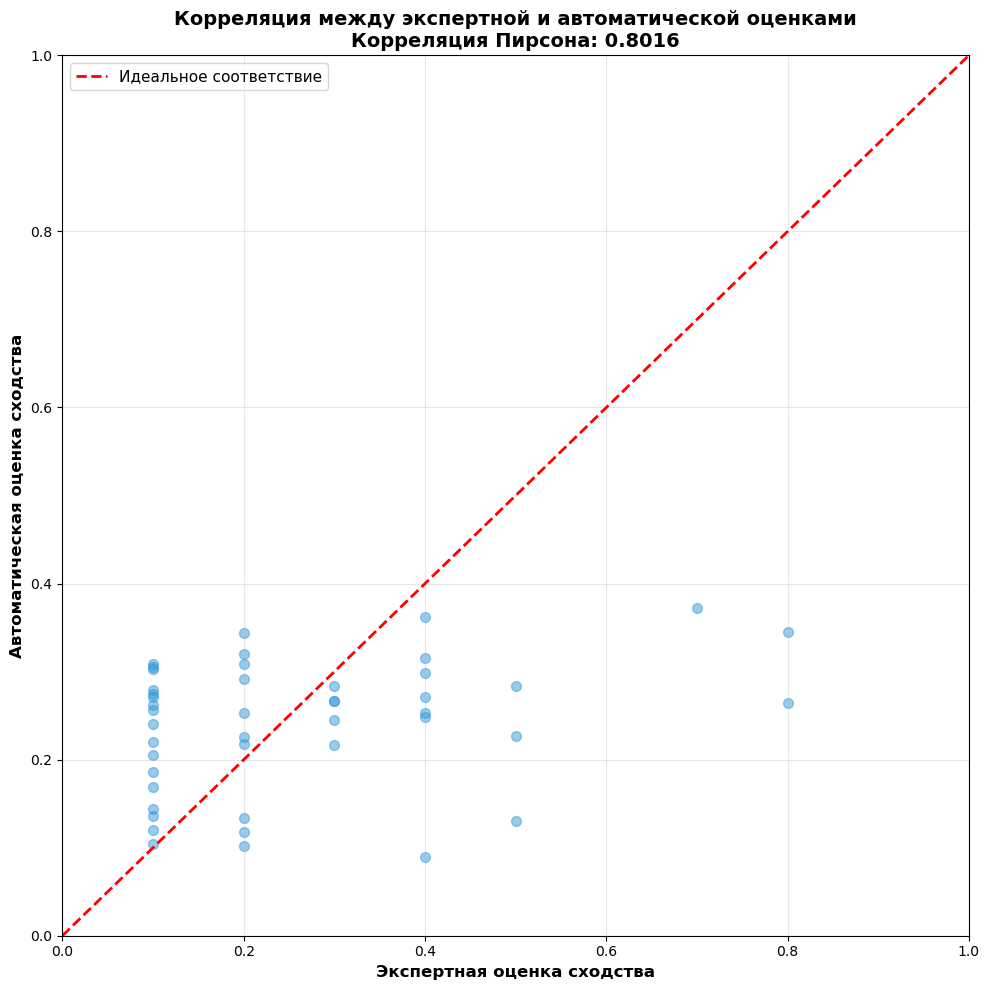


СОХРАНЕНИЕ РЕЗУЛЬТАТОВ
✓ Оптимальные веса → optimal_weights.csv
✓ Автоматическая матрица → automatic_similarity_matrix.csv
✓ Детальное сравнение → matrix_comparison.csv
✓ Сводная статистика → optimization_summary.csv

ОПТИМИЗАЦИЯ ЗАВЕРШЕНА УСПЕШНО!

🎯 Финальные результаты:
   • Оптимальный вес TF-IDF:   0.6353
   • Оптимальный вес Word2Vec: 0.1232
   • Оптимальный вес BERT:     0.2415
   • Расстояние Фробениуса:    1.708621
   • Корреляция:               0.8016
   • Улучшение:                28.61%


In [31]:
# Оптимизация весов векторизации для минимизации расстояния до экспертной матрицы
# Используется генетический алгоритм (GA) из библиотеки mealpy

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import torch
from transformers import BertTokenizer, BertModel
from mealpy import FloatVar
from mealpy.evolutionary_based import GA
import nltk
from nltk.corpus import stopwords
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

# ==============================================================================
# 1. ЗАГРУЗКА И ПОДГОТОВКА ДАННЫХ
# ==============================================================================

print("="*80)
print("ЗАГРУЗКА ДАННЫХ")
print("="*80)

# Загрузка данных
expert_matrix_df = pd.read_excel('expert_matrix_articles.xlsx', header=0, index_col=0)
articles_df = pd.read_excel('selected_articles.xlsx')

expert_matrix = expert_matrix_df.values
n_articles = len(articles_df)

print(f"✓ Загружено статей: {n_articles}")
print(f"✓ Размер экспертной матрицы: {expert_matrix.shape}")

# Подготовка стоп-слов
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('russian'))

def preprocess_text(text):
    """Предобработка текста: токенизация и удаление стоп-слов"""
    if not isinstance(text, str):
        return []
    tokens = simple_preprocess(text, deacc=True, min_len=3)
    return [token for token in tokens if token not in stop_words]

texts = articles_df['text'].fillna('').tolist()
tokenized_texts = [preprocess_text(text) for text in texts]

print(f"✓ Тексты предобработаны")

# ==============================================================================
# 2. ВЕКТОРИЗАЦИЯ ТЕКСТОВ
# ==============================================================================

print("\n" + "="*80)
print("ВЕКТОРИЗАЦИЯ ТЕКСТОВ")
print("="*80)

# --- TF-IDF векторизация ---
print("\n[1/3] Создание TF-IDF эмбеддингов...")
tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words=list(stop_words))
texts_str = [' '.join(tokens) for tokens in tokenized_texts]
tfidf_matrix = tfidf_vectorizer.fit_transform(texts_str).toarray()
tfidf_similarity = cosine_similarity(tfidf_matrix)
print(f"✓ TF-IDF матрица создана: {tfidf_matrix.shape}")

# --- Word2Vec векторизация ---
print("\n[2/3] Создание Word2Vec эмбеддингов...")
w2v_model = Word2Vec(
    sentences=tokenized_texts,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    epochs=20
)

def get_w2v_embedding(tokens):
    """Получение усредненного Word2Vec эмбеддинга для текста"""
    vectors = [w2v_model.wv[token] for token in tokens if token in w2v_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(w2v_model.vector_size)

w2v_embeddings = np.array([get_w2v_embedding(tokens) for tokens in tokenized_texts])
w2v_similarity = cosine_similarity(w2v_embeddings)
print(f"✓ Word2Vec матрица создана: {w2v_embeddings.shape}")

# --- BERT векторизация ---
print("\n[3/3] Создание BERT эмбеддингов...")
try:
    tokenizer = BertTokenizer.from_pretrained('cointegrated/rubert-tiny')
    model = BertModel.from_pretrained('cointegrated/rubert-tiny')
    model.eval()
    
    def get_bert_embedding(text, max_length=512):
        """Получение BERT эмбеддинга для текста"""
        inputs = tokenizer(
            text,
            return_tensors='pt',
            truncation=True,
            max_length=max_length,
            padding='max_length'
        )
        
        with torch.no_grad():
            outputs = model(**inputs)
        
        return outputs.last_hidden_state.mean(dim=1).numpy().flatten()
    
    bert_embeddings = []
    batch_size = 4
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        for text in batch:
            bert_embeddings.append(get_bert_embedding(text))
        
        if (i + batch_size) % 20 == 0 or (i + batch_size) >= len(texts):
            print(f"  Обработано {min(i + batch_size, len(texts))}/{len(texts)} статей")
    
    bert_embeddings = np.array(bert_embeddings)
    bert_similarity = cosine_similarity(bert_embeddings)
    print(f"✓ BERT матрица создана: {bert_embeddings.shape}")
    
except Exception as e:
    print(f"⚠ Ошибка при загрузке BERT: {e}")
    print(f"⚠ Использую случайные эмбеддинги для демонстрации")
    bert_embeddings = np.random.randn(n_articles, 312)
    bert_similarity = cosine_similarity(bert_embeddings)

# ==============================================================================
# 3. НОРМАЛИЗАЦИЯ МАТРИЦ СХОДСТВА
# ==============================================================================

def normalize_similarity_matrix(matrix):
    """Нормализация матрицы сходства к диапазону [0, 1]"""
    matrix_norm = matrix.copy()
    min_val, max_val = matrix_norm.min(), matrix_norm.max()
    
    if max_val > min_val:
        matrix_norm = (matrix_norm - min_val) / (max_val - min_val)
    
    np.fill_diagonal(matrix_norm, 1.0)
    return matrix_norm

tfidf_similarity_norm = normalize_similarity_matrix(tfidf_similarity)
w2v_similarity_norm = normalize_similarity_matrix(w2v_similarity)
bert_similarity_norm = normalize_similarity_matrix(bert_similarity)

print("\n✓ Все матрицы нормализованы")

# ==============================================================================
# 4. ОПРЕДЕЛЕНИЕ ЗАДАЧИ ОПТИМИЗАЦИИ
# ==============================================================================

def create_automatic_matrix(weights):
    """
    Создание автоматической матрицы сходства с заданными весами
    
    Parameters:
    -----------
    weights : array-like, shape (3,)
        Веса для [TF-IDF, Word2Vec, BERT]
    
    Returns:
    --------
    weighted_matrix : ndarray
        Взвешенная матрица сходства
    """
    # Нормализация весов
    weights = np.maximum(weights, 0)  # Неотрицательность
    total = weights.sum()
    weights = weights / total if total > 0 else np.ones(3) / 3
    
    # Взвешенная комбинация
    weighted_matrix = (
        weights[0] * tfidf_similarity_norm +
        weights[1] * w2v_similarity_norm +
        weights[2] * bert_similarity_norm
    )
    
    return weighted_matrix

def objective_function(solution):
    """
    Целевая функция для оптимизации: расстояние Фробениуса
    между автоматической и экспертной матрицами
    """
    auto_matrix = create_automatic_matrix(solution)
    
    # Ограничиваем размер для сравнения
    n = min(auto_matrix.shape[0], expert_matrix.shape[0])
    
    # Расстояние Фробениуса
    distance = np.linalg.norm(
        auto_matrix[:n, :n] - expert_matrix[:n, :n],
        ord='fro'
    )
    
    return distance

# ==============================================================================
# 5. ОПТИМИЗАЦИЯ ВЕСОВ С ПОМОЩЬЮ ГЕНЕТИЧЕСКОГО АЛГОРИТМА
# ==============================================================================

print("\n" + "="*80)
print("ОПТИМИЗАЦИЯ ВЕСОВ С ПОМОЩЬЮ ГЕНЕТИЧЕСКОГО АЛГОРИТМА")
print("="*80)

# Определение границ для весов
bounds = [
    FloatVar(lb=0.0, ub=1.0, name="w_tfidf"),
    FloatVar(lb=0.0, ub=1.0, name="w_w2v"),
    FloatVar(lb=0.0, ub=1.0, name="w_bert")
]

# Параметры генетического алгоритма
GA_PARAMS = {
    'epoch': 50,                    # Количество поколений
    'pop_size': 30,                 # Размер популяции
    'pc': 0.9,                      # Вероятность скрещивания
    'pm': 0.1,                      # Вероятность мутации
    'selection': 'tournament',      # Метод селекции
    'k_way': 0.2,                   # Параметр турнирной селекции
    'crossover': 'uniform',         # Оператор скрещивания
    'mutation': 'flip'              # Оператор мутации (только 'flip' или 'swap' для непрерывных переменных)
}

print(f"\nПараметры GA:")
for key, value in GA_PARAMS.items():
    print(f"  {key}: {value}")

# Создание и запуск оптимизатора
problem_dict = {
    "obj_func": objective_function,
    "bounds": bounds,
    "minmax": "min"
}

optimizer = GA.BaseGA(**GA_PARAMS)
best_agent = optimizer.solve(problem_dict)

# Извлечение результатов
optimal_weights = best_agent.solution
optimal_weights = np.maximum(optimal_weights, 0)
optimal_weights = optimal_weights / optimal_weights.sum()

best_distance = best_agent.target.fitness

print("\n" + "="*80)
print("РЕЗУЛЬТАТЫ ОПТИМИЗАЦИИ")
print("="*80)

print(f"\n📊 Оптимальные веса:")
for method, weight in zip(['TF-IDF', 'Word2Vec', 'BERT'], optimal_weights):
    bar = '█' * int(weight * 50)
    print(f"  {method:10} {weight:.4f} ({weight*100:5.1f}%) {bar}")

print(f"\n📏 Минимальное расстояние до экспертной матрицы: {best_distance:.6f}")

# ==============================================================================
# 6. АНАЛИЗ РЕЗУЛЬТАТОВ
# ==============================================================================

print("\n" + "="*80)
print("АНАЛИЗ РЕЗУЛЬТАТОВ")
print("="*80)

# Создание финальной автоматической матрицы
final_auto_matrix = create_automatic_matrix(optimal_weights)

# Расстояния для отдельных методов
n = min(final_auto_matrix.shape[0], expert_matrix.shape[0])

dist_tfidf = np.linalg.norm(
    tfidf_similarity_norm[:n, :n] - expert_matrix[:n, :n], ord='fro'
)
dist_w2v = np.linalg.norm(
    w2v_similarity_norm[:n, :n] - expert_matrix[:n, :n], ord='fro'
)
dist_bert = np.linalg.norm(
    bert_similarity_norm[:n, :n] - expert_matrix[:n, :n], ord='fro'
)

print(f"\n📉 Расстояния для отдельных методов:")
print(f"  TF-IDF:        {dist_tfidf:.6f}")
print(f"  Word2Vec:      {dist_w2v:.6f}")
print(f"  BERT:          {dist_bert:.6f}")
print(f"  Комбинация:    {best_distance:.6f}")

# Улучшение относительно лучшего отдельного метода
best_single = min(dist_tfidf, dist_w2v, dist_bert)
improvement = (best_single - best_distance) / best_single * 100

print(f"\n✨ Улучшение относительно лучшего отдельного метода: {improvement:.2f}%")

# Примеры сравнения пар статей
print(f"\n📋 Примеры сходства статей (экспертная vs автоматическая):")
print(f"{'Пара':<15} {'Экспертная':<12} {'Автоматическая':<15} {'Разница':<10}")
print("-" * 55)

pairs = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (0, 5), (1, 4), (2, 5)]
for i, j in pairs:
    if i < n and j < n:
        expert_val = expert_matrix[i, j]
        auto_val = final_auto_matrix[i, j]
        diff = abs(expert_val - auto_val)
        print(f"{i+1} ↔ {j+1:<10} {expert_val:<12.3f} {auto_val:<15.3f} {diff:<10.3f}")

# Статистика различий
differences = []
for i in range(n):
    for j in range(i+1, n):
        differences.append(abs(expert_matrix[i, j] - final_auto_matrix[i, j]))

print(f"\n📊 Статистика различий по всем парам ({len(differences)} пар):")
print(f"  Среднее:             {np.mean(differences):.4f}")
print(f"  Медиана:             {np.median(differences):.4f}")
print(f"  Стандартное откл.:   {np.std(differences):.4f}")
print(f"  Минимум:             {np.min(differences):.4f}")
print(f"  Максимум:            {np.max(differences):.4f}")

# Корреляция Пирсона
flat_expert = expert_matrix[:n, :n].flatten()
flat_auto = final_auto_matrix[:n, :n].flatten()
correlation = np.corrcoef(flat_expert, flat_auto)[0, 1]

print(f"\n🔗 Корреляция Пирсона между матрицами: {correlation:.4f}")

# ==============================================================================
# 7. ВИЗУАЛИЗАЦИЯ
# ==============================================================================

print("\n" + "="*80)
print("ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Анализ матриц сходства и результатов оптимизации', 
             fontsize=16, fontweight='bold')

# 1. Экспертная матрица
im1 = axes[0, 0].imshow(expert_matrix[:n, :n], cmap='RdYlGn', vmin=0, vmax=1)
axes[0, 0].set_title('Экспертная матрица', fontweight='bold')
axes[0, 0].set_xlabel('Статья')
axes[0, 0].set_ylabel('Статья')
plt.colorbar(im1, ax=axes[0, 0])

# 2. Автоматическая матрица
im2 = axes[0, 1].imshow(final_auto_matrix[:n, :n], cmap='RdYlGn', vmin=0, vmax=1)
axes[0, 1].set_title('Автоматическая матрица (оптимизированная)', fontweight='bold')
axes[0, 1].set_xlabel('Статья')
axes[0, 1].set_ylabel('Статья')
plt.colorbar(im2, ax=axes[0, 1])

# 3. Разница между матрицами
difference_matrix = np.abs(expert_matrix[:n, :n] - final_auto_matrix[:n, :n])
im3 = axes[0, 2].imshow(difference_matrix, cmap='Reds', vmin=0, vmax=1)
axes[0, 2].set_title('Абсолютная разница', fontweight='bold')
axes[0, 2].set_xlabel('Статья')
axes[0, 2].set_ylabel('Статья')
plt.colorbar(im3, ax=axes[0, 2])

# 4. Распределение весов
methods = ['TF-IDF', 'Word2Vec', 'BERT']
colors = ['#3498db', '#e74c3c', '#2ecc71']
axes[1, 0].bar(methods, optimal_weights, color=colors, alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Оптимальные веса методов', fontweight='bold')
axes[1, 0].set_ylabel('Вес')
axes[1, 0].set_ylim([0, 1])
for i, (method, weight) in enumerate(zip(methods, optimal_weights)):
    axes[1, 0].text(i, weight + 0.02, f'{weight:.3f}', 
                    ha='center', fontweight='bold')

# 5. Сравнение расстояний
distances = [dist_tfidf, dist_w2v, dist_bert, best_distance]
labels = ['TF-IDF', 'Word2Vec', 'BERT', 'Комбинация']
colors_dist = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6']
bars = axes[1, 1].bar(labels, distances, color=colors_dist, alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Сравнение расстояний до экспертной матрицы', fontweight='bold')
axes[1, 1].set_ylabel('Расстояние Фробениуса')
axes[1, 1].tick_params(axis='x', rotation=45)
for bar, dist in zip(bars, distances):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{dist:.4f}', ha='center', va='bottom', fontweight='bold')

# 6. Гистограмма различий
axes[1, 2].hist(differences, bins=30, color='#e67e22', alpha=0.7, edgecolor='black')
axes[1, 2].axvline(np.mean(differences), color='red', linestyle='--', 
                   linewidth=2, label=f'Среднее: {np.mean(differences):.4f}')
axes[1, 2].axvline(np.median(differences), color='blue', linestyle='--', 
                   linewidth=2, label=f'Медиана: {np.median(differences):.4f}')
axes[1, 2].set_title('Распределение различий между матрицами', fontweight='bold')
axes[1, 2].set_xlabel('Абсолютная разница')
axes[1, 2].set_ylabel('Частота')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

# Дополнительная визуализация: scatter plot
fig, ax = plt.subplots(figsize=(10, 10))

# Извлекаем верхнетреугольные элементы (без диагонали)
mask = np.triu(np.ones((n, n), dtype=bool), k=1)
expert_values = expert_matrix[:n, :n][mask]
auto_values = final_auto_matrix[:n, :n][mask]

ax.scatter(expert_values, auto_values, alpha=0.5, s=50, color='#3498db')
ax.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Идеальное соответствие')
ax.set_xlabel('Экспертная оценка сходства', fontsize=12, fontweight='bold')
ax.set_ylabel('Автоматическая оценка сходства', fontsize=12, fontweight='bold')
ax.set_title(f'Корреляция между экспертной и автоматической оценками\n' + 
             f'Корреляция Пирсона: {correlation:.4f}', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

# ==============================================================================
# 8. СОХРАНЕНИЕ РЕЗУЛЬТАТОВ
# ==============================================================================

print("\n" + "="*80)
print("СОХРАНЕНИЕ РЕЗУЛЬТАТОВ")
print("="*80)

# Оптимальные веса
weights_df = pd.DataFrame({
    'Метод': ['TF-IDF', 'Word2Vec', 'BERT'],
    'Оптимальный_вес': optimal_weights,
    'Процент': optimal_weights * 100
})
weights_df.to_csv('optimal_weights.csv', index=False)
print("✓ Оптимальные веса → optimal_weights.csv")

# Автоматическая матрица
auto_matrix_df = pd.DataFrame(
    final_auto_matrix[:n, :n],
    index=[f"Статья_{i+1}" for i in range(n)],
    columns=[f"Статья_{i+1}" for i in range(n)]
)
auto_matrix_df.to_csv('automatic_similarity_matrix.csv')
print("✓ Автоматическая матрица → automatic_similarity_matrix.csv")

# Сравнение матриц
comparison_data = []
for i in range(n):
    for j in range(i+1, n):
        comparison_data.append({
            'Статья_i': i+1,
            'Статья_j': j+1,
            'Экспертная_оценка': expert_matrix[i, j],
            'Автоматическая_оценка': final_auto_matrix[i, j],
            'Абсолютная_разница': abs(expert_matrix[i, j] - final_auto_matrix[i, j]),
            'Относительная_разница_%': abs(expert_matrix[i, j] - final_auto_matrix[i, j]) / 
                                       max(expert_matrix[i, j], 0.001) * 100
        })

comparison_df = pd.DataFrame(comparison_data)
comparison_df.to_csv('matrix_comparison.csv', index=False)
print("✓ Детальное сравнение → matrix_comparison.csv")

# Сводная статистика
summary_df = pd.DataFrame({
    'Метрика': [
        'Расстояние TF-IDF',
        'Расстояние Word2Vec',
        'Расстояние BERT',
        'Расстояние комбинированной матрицы',
        'Улучшение относительно лучшего метода (%)',
        'Корреляция Пирсона',
        'Средняя разница',
        'Медиана разницы',
        'Стандартное отклонение разницы'
    ],
    'Значение': [
        dist_tfidf,
        dist_w2v,
        dist_bert,
        best_distance,
        improvement,
        correlation,
        np.mean(differences),
        np.median(differences),
        np.std(differences)
    ]
})
summary_df.to_csv('optimization_summary.csv', index=False)
print("✓ Сводная статистика → optimization_summary.csv")

print("\n" + "="*80)
print("ОПТИМИЗАЦИЯ ЗАВЕРШЕНА УСПЕШНО!")
print("="*80)
print(f"\n🎯 Финальные результаты:")
print(f"   • Оптимальный вес TF-IDF:   {optimal_weights[0]:.4f}")
print(f"   • Оптимальный вес Word2Vec: {optimal_weights[1]:.4f}")
print(f"   • Оптимальный вес BERT:     {optimal_weights[2]:.4f}")
print(f"   • Расстояние Фробениуса:    {best_distance:.6f}")
print(f"   • Корреляция:               {correlation:.4f}")
print(f"   • Улучшение:                {improvement:.2f}%")